In [1]:
import logging, gensim, bz2
from gensim import corpora, models, similarities
from collections import defaultdict
import nltk
import pyLDAvis.gensim
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from collections import defaultdict

# Let's retrieve the documents. A document is a set of tweets of a user

I have a lot of tweets of Hillary Clinton in several files. Those files are the documents we'll use to train our LDA model

In [2]:
import os
all_docs = []
clinton_docs = []
for file_name in os.listdir("/home/vagrant/shared/HillaryTweets"):
    file = open("/home/vagrant/shared/HillaryTweets/" + file_name)
    doc = file.read()
    clinton_docs.append(doc)
    all_docs.append(doc)

In [3]:
import os
trump_docs = []
for file_name in os.listdir("/home/vagrant/shared/TrumpTweets"):
    file = open("/home/vagrant/shared/TrumpTweets/" + file_name)
    doc = file.read()
    trump_docs.append(doc)
    all_docs.append(doc)

# Preprocessing
We'll remove stopwords, words that appears only once, unigrams and bigrams.

## Stemming
“stemming,” “stemmer,” “stemmed,” all have similar meanings; stemming reduces those terms to “stem.” This is important for topic modeling, which would otherwise view those terms as separate entities and reduce their importance in the model.

Stemming is flexible and some methods are more aggressive. The Porter stemming algorithm is the most widely used method.
https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

In [4]:
clinton_texts = []
trump_texts = []
all_texts = []
tokenizer = RegexpTokenizer(r'\w+')
stoplist_tw=['amp','get','got','hey','hmm','hoo','hop','iep','let','ooo','par',
            'pdt','pln','pst','wha','yep','yer','aest','didn','nzdt','via',
            'one','com','new','like','great','make','top','awesome','best',
            'good','wow','yes','say','yay','would','thanks','thank','going',
            'new','use','should','could','best','really','see','want','nice',
            'while','know']

unigrams = [ w for doc in all_docs for w in doc if len(w)==1]
bigrams  = [ w for doc in all_docs for w in doc if len(w)==2]

en_stop  = set(nltk.corpus.stopwords.words("english") + stoplist_tw
                + unigrams + bigrams)
p_stemmer = PorterStemmer()
# loop through document list
for i in clinton_docs:
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [i for i in stopped_tokens]
    
    # add tokens to list
    clinton_texts.append(stemmed_tokens)
    all_texts.append(stemmed_tokens)

# remove words that appear only once and the most common ones ( if the word is common for many documents, it does not distinguished those and should be neglected.)
# http://datascience.stackexchange.com/questions/5941/need-help-with-lda-for-selecting-features
from collections import defaultdict
frequency = defaultdict(int)
for text in clinton_texts:
    for token in text:
        frequency[token] += 1
        
import operator
for i in xrange(3):
    most_common_word = max(frequency.iteritems(), key=operator.itemgetter(1))[0]
    print most_common_word
    print frequency[most_common_word]
    frequency.pop(most_common_word, None)

frequency.pop('hillary', None)
frequency.pop('clinton', None)
frequency.pop('donald', None)
frequency.pop('trump', None)
clinton_texts = [[token for token in text if frequency[token] > 1 ]
          for text in clinton_texts]

# loop through document list
for i in trump_docs:
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [i for i in stopped_tokens]
    
    # add tokens to list
    trump_texts.append(stemmed_tokens)
    all_texts.append(stemmed_tokens)

# remove words that appear only once and the most common ones ( if the word is common for many documents, it does not distinguished those and should be neglected.)
# http://datascience.stackexchange.com/questions/5941/need-help-with-lda-for-selecting-features
from collections import defaultdict
frequency = defaultdict(int)
for text in trump_texts:
    for token in text:
        frequency[token] += 1
        
import operator
for i in xrange(3):
    most_common_word = max(frequency.iteritems(), key=operator.itemgetter(1))[0]
    print most_common_word
    print frequency[most_common_word]
    frequency.pop(most_common_word, None)

frequency.pop('hillary', None)
frequency.pop('clinton', None)
frequency.pop('donald', None)
frequency.pop('trump', None)
trump_texts = [[token for token in text if frequency[token] > 1 ]
          for text in trump_texts]

hillary
168
trump
140
women
81
hillary
87
trump
85
trump2016
60


In [5]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(all_texts)
    
# convert tokenized documents into a document-term matrix
clinton_corpus = [dictionary.doc2bow(text) for text in clinton_texts]
trump_corpus = [dictionary.doc2bow(text) for text in trump_texts]

# LDA Model

In [6]:
clinton_model = gensim.models.ldamodel.LdaModel(clinton_corpus, num_topics=10, id2word = dictionary, passes=20, alpha=0.0001)

In [7]:
#clinton_viz_data =  pyLDAvis.gensim.prepare(clinton_model, clinton_corpus, dictionary)
#pyLDAvis.display(clinton_viz_data)

In [8]:
trump_model = gensim.models.ldamodel.LdaModel(trump_corpus, num_topics=10, id2word = dictionary, passes=20, alpha=0.0001)

In [9]:
#trump_viz_data =  pyLDAvis.gensim.prepare(trump_model, trump_corpus, dictionary)
#pyLDAvis.display(trump_viz_data)

In [40]:
def compute_similarity_two_topics(list_topic1, list_topic2):
    from collections import defaultdict
    from math import sqrt
    v_t0 = dict(list_topic1) #vector of the first topic
    dic = defaultdict(list)
    v_t1 = dict(list_topic2) #vector of the second topic
    norm_v_t0 = 0
    norm_v_t1 = 0
    for key in v_t0:  #multiply components of both vectors
        norm_v_t0 =  norm_v_t0 + (v_t0[key] *  v_t0[key]) #obtain the norm of the first vector
        if key in v_t1:
            dic[key] = v_t0[key] * v_t1[key]
            print key
    norm_v_t0 = sqrt(norm_v_t0) #last step to get the norm of the first vector

    for key in v_t1: #obtain the norm of the second vector
        norm_v_t1 =  norm_v_t1 + (v_t1[key] *  v_t1[key])
    norm_v_t1 = sqrt(norm_v_t1)

    similarity = 0
    for key in dic:
        print 'dic[key] = ' + str(dic[key])
        print '(norm_v_t0 * norm_v_t1) = ' + str((norm_v_t0 * norm_v_t1))
        similarity = similarity + dic[key]/(norm_v_t0 * norm_v_t1)
    return similarity

In [32]:
#Uses weighted arithmetic mean.
#alpha: weight given to similarities between topics greater than threshold
#beta: weight given to similarities between topics lower than threshold
def compare_models(model1, model2, threshold, alpha, beta):
    sim = []
    numerator = 0
    denominator = 0
    for i in xrange(model1.num_topics):
        max_similarity = 0
        equivalent_topic_in_model_b = 0
        for j in xrange(model2.num_topics):
            similarity = compute_similarity_two_topics(model1.get_topic_terms(i), model2.get_topic_terms(j))
            if max_similarity < similarity:
                max_similarity = similarity
                equivalent_topic_in_model_b = j
        if max_similarity >= threshold:
            numerator = numerator + alpha * max_similarity
            denominator = denominator + alpha
            sim.append(max_similarity)
            print str(i) + ' ' + str(equivalent_topic_in_model_b) + ' ' + str(max_similarity)
            #print 'Model 1' 
            #for tup in model1.get_topic_terms(i):
            #    print dictionary[tup[0]] + ' ' + str(tup[1])
            #print 'Model 2' 
            #for tup in model2.get_topic_terms(j):
            #    print dictionary[tup[0]] + ' ' + str(tup[1])
        else:
            numerator = numerator + beta * max_similarity
            denominator = denominator + beta
            
    return numerator/denominator

In [33]:
compare_models(clinton_model, clinton_model, 0.2, 1, 0.5)

0 0 1.0
1 1 1.0
2 2 1.0
3 3 1.0
4 4 1.0
5 5 1.0
6 6 1.0
7 7 1.0
8 8 1.0
9 9 1.0


1.0

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag()

In [34]:
#Uses weighted arithmetic mean. Show a word clound with the similar topics found
#alpha: weight given to similarities between topics greater than threshold
#beta: weight given to similarities between topics lower than threshold
def compare_models_and_viz(model1, model2, threshold, alpha, beta):
    model1_topics = []
    for i in xrange(model1.num_topics):
        #print i
        words = []
        for tup in model1.get_topic_terms(i):
            t = ( dictionary[tup[0]],tup[1])
            words.append(t)
            #print dictionary[tup[0]] + ' ' + str(tup[1])
        model1_topics.append(words)
    
    model2_topics = []
    for i in xrange(model2.num_topics):
        #print i
        words = []
        for tup in model2.get_topic_terms(i):
            t = ( dictionary[tup[0]],tup[1])
            words.append(t)
            #print dictionary[tup[0]] + ' ' + str(tup[1])
        model2_topics.append(words)
    
    
    sim = []
    numerator = 0
    denominator = 0
    for i in xrange(model1.num_topics):
        max_similarity = 0
        equivalent_topic_in_model_b = 0
        for j in xrange(model2.num_topics):
            similarity = compute_similarity_two_topics(model1.get_topic_terms(i), model2.get_topic_terms(j))
            if max_similarity < similarity:
                max_similarity = similarity
                equivalent_topic_in_model_b = j
        if max_similarity >= threshold:
            numerator = numerator + alpha * max_similarity
            denominator = denominator + alpha
            sim.append(max_similarity)
            print str(i) + ' ' + str(equivalent_topic_in_model_b) + ' ' + str(max_similarity)
            wordcloud = WordCloud(width=800, height=600, relative_scaling=.8)\
                .generate_from_frequencies(model1_topics[i])
            plt.imshow(wordcloud)
            plt.axis("off")
            plt.show()
            wordcloud = WordCloud(width=800, height=600, relative_scaling=.8)\
                .generate_from_frequencies(model2_topics[equivalent_topic_in_model_b])
            plt.imshow(wordcloud)
            plt.axis("off")
            plt.show()
            #print 'Model 1' 
            #for tup in model1.get_topic_terms(i):
            #    print dictionary[tup[0]] + ' ' + str(tup[1])
            #print 'Model 2' 
            #for tup in model2.get_topic_terms(j):
            #    print dictionary[tup[0]] + ' ' + str(tup[1])
        else:
            numerator = numerator + beta * max_similarity
            denominator = denominator + beta
    return numerator/denominator

9 4 0.238554878974


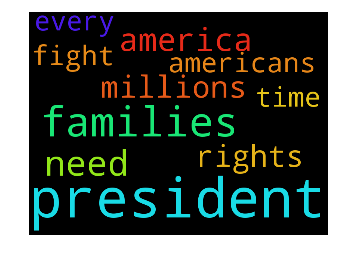

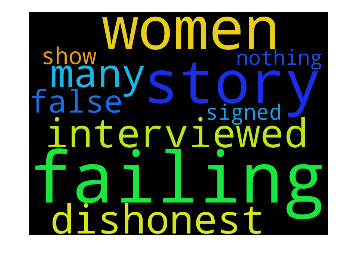

0.23855487897393687

In [35]:
compare_models_and_viz(clinton_model, trump_model, 0.2, 1, 0)

In [18]:
for i in xrange(clinton_model.num_topics):
    print i
    words = []
    for tup in clinton_model.get_topic_terms(i):
        t = ( dictionary[tup[0]],tup[1])
        print dictionary[tup[0]] + ' ' + str(tup[1])

0
love 0.00847865751556
families 0.00687294975925
made 0.00687254421972
back 0.00687253091768
gets 0.00687241050129
america 0.00687219620035
demagogue 0.00687177935282
york 0.00525054016572
vote 0.00519672964509
win 0.00519653391286
1
gun 0.012643450595
families 0.0119894261172
rights 0.00953697435187
demdebate 0.00852987430216
child 0.00819453767894
every 0.00810765181291
care 0.00761566565514
americans 0.006853414673
things 0.00600785847778
us 0.00600752978719
2
families 0.00719071773783
tax 0.00719064755768
people 0.00543744952606
demdebate 0.00543715381243
us 0.00543698151735
americans 0.00543683169103
climate 0.00543662526454
need 0.0054365538034
election 0.00543638162623
left 0.00543638046167
3
need 0.0162803078784
today 0.0115905139708
vote 0.00984921745263
voting 0.00869021698228
pay 0.00767859911568
rt 0.00751651770215
equal 0.00617295281975
primary 0.00617240999331
act 0.0061723086989
men 0.00617165764184
4
qualified 0.0152377113226
rights 0.0123393491405
president 0.00866425

In [20]:
for i in xrange(trump_model.num_topics):
    print i
    words = []
    for tup in trump_model.get_topic_terms(i):
        t = ( dictionary[tup[0]],tup[1])
        print dictionary[tup[0]] + ' ' + str(tup[1])


0
warren 0.0171381720563
elizabeth 0.0171380650459
goofy 0.017137986723
crooked 0.0147417645978
american 0.0130829202437
makeamericagreatagain 0.0114864039921
done 0.00911285830836
native 0.00812070423095
america 0.00777464614904
senator 0.00702945300051
1
delegates 0.00949064010191
people 0.00840787435172
party 0.00831029134977
campaign 0.00830896124216
tonight 0.00799752260125
cruz 0.00725517389321
republican 0.00667960955145
poll 0.0062901992281
00 0.00611307996527
enjoy 0.00610122083636
2
ted 0.0140085251723
lyin 0.0120067306186
cruz 0.0112961084842
crooked 0.0111199829624
people 0.0104548091413
big 0.00926795188428
never 0.00740922887143
win 0.0072239717528
today 0.00720697805574
000 0.00687837867746
3
jobs 0.00774906686874
women 0.00774837456434
show 0.00622977951919
economy 0.00622872493373
conference 0.00622827993173
press 0.00622826087234
strong 0.00622771890997
amazing 0.00471064304342
bad 0.00471064205221
many 0.00471028721595
4
york 0.0100768264358
time 0.00872134433836
cru

In [41]:
compute_similarity_two_topics(clinton_topics[9], trump_topics[4])

time
president
dic[key] = 0.000103703181714
(norm_v_t0 * norm_v_t1) = 0.000686959007772
dic[key] = 6.01742412447e-05
(norm_v_t0 * norm_v_t1) = 0.000686959007772


0.23855487897393687